In [1]:
# import warnings
# warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer

from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, plot_confusion_matrix, precision_score, plot_roc_curve, make_scorer

from yellowbrick.classifier import ROCAUC

from gensim.models import word2vec

from wordcloud import WordCloud

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stone\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
def evaluate(estimator, X_train, X_val, y_train, y_val, roc_auc='proba', output = False):

    
    #     grab predictions
    train_preds = estimator.predict(X_train)
    val_preds = estimator.predict(X_val)
    
#     output needed for roc_auc score
    if roc_auc == 'skip':
        train_out = False
        val_out = False
    elif roc_auc == 'dec': # not all classifiers have a decision function
        train_out = estimator.decision_function(X_train)
        val_out = estimator.decision_function(X_val)
    elif roc_auc == 'proba':
        try:
            train_out = estimator.predict_proba(X_train)
            val_out = estimator.predict_proba(X_val)
        except AttributeError:
            train_out = estimator.predict(X_train)
            val_out = estimator.predict(X_val)

    else:
        raise Exception("The value for roc_auc should be 'skip', 'dec', or 'proba'.")
    
    ac = accuracy_score(y_train, train_preds)
    try:
        f1 = f1_score(y_train, train_preds, pos_label='Positive emotion')
        ras = roc_auc_score(y_train, train_out)
        pr = precision_score(y_train, train_preds, pos_label='Positive emotion')

    except ValueError:
        try:
            f1 = f1_score(y_train, train_preds, pos_label='Positive emotion')
            ras = roc_auc_score(y_train, train_out[:,1])
            pr = precision_score(y_train, train_preds, pos_label='Positive emotion')
        except ValueError:
            f1 = f1_score(y_train, train_preds, pos_label='Positive emotion', average='macro')
            ras = roc_auc_score(y_train, train_out, multi_class='ovo')
            pr = precision_score(y_train, train_preds, pos_label='Positive emotion', average='macro')

    
    if output == True:
        print('Train Scores')
        print('------------')
        print(f'Accuracy: {ac}')
        print(f'F1 Score: {f1}')
        if type(train_out) == np.ndarray:
            print(f'ROC-AUC: {ras}')
        print(f'Precision: {pr}')

    ac = accuracy_score(y_val, val_preds)
    try:
        f1 = f1_score(y_val, val_preds, pos_label='Positive emotion')
        ras = roc_auc_score(y_test, val_out)
        pr = precision_score(y_val, val_preds, pos_label='Positive emotion')

    except ValueError:
        try:
            f1 = f1_score(y_val, val_preds, pos_label='Positive emotion')
            ras = roc_auc_score(y_test, val_out[:,1])
            pr = precision_score(y_val, val_preds, pos_label='Positive emotion')
        except ValueError:
            f1 = f1_score(y_test, val_preds, pos_label='Positive emotion', average='macro')
            ras = roc_auc_score(y_val, val_out, multi_class='ovo')
            pr = precision_score(y_val, val_preds, pos_label='Positive emotion', average='macro')
    
    if output == True:
        print('-----------------------------------')
        print('Val Scores')
        print('-----------')
        print(f'Accuracy: {ac}')
        print(f'F1 Score: {f1}')
        if type(val_out) == np.ndarray:
            print(f'ROC-AUC: {ras}')
        print(f'Precision: {pr}')
    

        plot_confusion_matrix(estimator, X_val, y_val, values_format=',.5g')
        plt.show()
      
        
def run_model(name, clf, X_train, X_val, y_train, y_val):

    clf.fit(X_train, y_train)
    evaluate(clf, X_train, X_val, y_train, y_val, output=True)
    
    visualizer = ROCAUC(clf, classes = y_train.unique())
                                        
    # Fitting to the training data first then scoring with the test data                                    
    try:
        visualizer.fit(X_train, y_train)
        visualizer.score(X_val, y_val)
    except ValueError:
        visualizer.fit(X_train, y_train.map({'Positive emotion': 1, 'Negative emotion': 0}).astype(int))
        visualizer.score(X_val, y_val.map({'Positive emotion': 1, 'Negative emotion': 0}).astype(int))
    visualizer.show()
#     plot_roc_curve(clf, X_val, y_val)
#     plt.show()
    
    try:
        importances = sorted(list(zip(clf[name].feature_importances_, clf['tfidfv'].get_feature_names())))[-20:]
    except AttributeError:
        importances = sorted(list(zip(clf[name].coef_[0], clf['tfidfv'].get_feature_names())))[-20:]

    impts = pd.DataFrame(importances, columns=['impt', 'feat'])
    impts = impts.set_index('feat')
    impts.plot(kind='barh')
    for index, row in impts.sort_values('impt', ascending=False).iterrows():
        print(index)
        print('Positive Appearences: {}'.format(positive_fdist[index]))
        print('Negative Appearences: {}\n'.format(negative_fdist[index]))

In [3]:
# Importing the sentiment data. Need to encode with unicode escape probably due to unrecognized characters in a number of tweet_text values

df = pd.read_csv('judge-1377884607_tweet_product_company.csv', encoding='unicode_escape')
df

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [5]:
df.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [6]:
df['tweet_text'].value_counts()

RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #sxsw                                 5
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #sxsw                                              4
RT @mention Marissa Mayer: Google Will Connect the Digital &amp; Physical Worlds Through Mobile - {link} #SXSW                                 4
RT @mention Google to Launch Major New Social Network Called Circles, Possibly Today {link} #SXSW                                              3
RT @mention ÷¼ GO BEYOND BORDERS! ÷_ {link} ã_ #edchat #musedchat #sxsw #sxswi #classical #newTwitter                                       2
                                                                                                                                              ..
Great interview to @mention on Bloomberg TV about #Ipad2 to kick off #SxSW.#apple {link}                                          

In [7]:
df['emotion_in_tweet_is_directed_at'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: emotion_in_tweet_is_directed_at, dtype: int64

In [8]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [9]:
df.isnull().values.any()

True

In [10]:
df = df.replace(np.nan, 'Unknown')

Let's see what the most commonly tweeted words are

In [11]:
tokenized_review = []
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
for row in df['tweet_text']:
    for word in tokenizer.tokenize(row):
        tokenized_review.append(word)
#     except TypeError:
#         print(row)

tokenized_review

['wesley83',
 'I',
 'have',
 'a',
 '3G',
 'iPhone',
 'After',
 '3',
 'hrs',
 'tweeting',
 'at',
 'RISE',
 'Austin',
 'it',
 'was',
 'dead',
 'I',
 'need',
 'to',
 'upgrade',
 'Plugin',
 'stations',
 'at',
 'SXSW',
 'jessedee',
 'Know',
 'about',
 'fludapp',
 'Awesome',
 'iPad',
 'iPhone',
 'app',
 'that',
 "you'll",
 'likely',
 'appreciate',
 'for',
 'its',
 'design',
 'Also',
 "they're",
 'giving',
 'free',
 'Ts',
 'at',
 'SXSW',
 'swonderlin',
 'Can',
 'not',
 'wait',
 'for',
 'iPad',
 '2',
 'also',
 'They',
 'should',
 'sale',
 'them',
 'down',
 'at',
 'SXSW',
 'sxsw',
 'I',
 'hope',
 'this',
 "year's",
 'festival',
 "isn't",
 'as',
 'crashy',
 'as',
 'this',
 "year's",
 'iPhone',
 'app',
 'sxsw',
 'sxtxstate',
 'great',
 'stuff',
 'on',
 'Fri',
 'SXSW',
 'Marissa',
 'Mayer',
 'Google',
 'Tim',
 "O'Reilly",
 'tech',
 'books',
 'conferences',
 'amp',
 'Matt',
 'Mullenweg',
 'Wordpress',
 'teachntech00',
 'New',
 'iPad',
 'Apps',
 'For',
 'SpeechTherapy',
 'And',
 'Communication',
 'A

In [12]:
fdist = FreqDist(tokenized_review)
print(fdist)

<FreqDist with 12540 samples and 164440 outcomes>


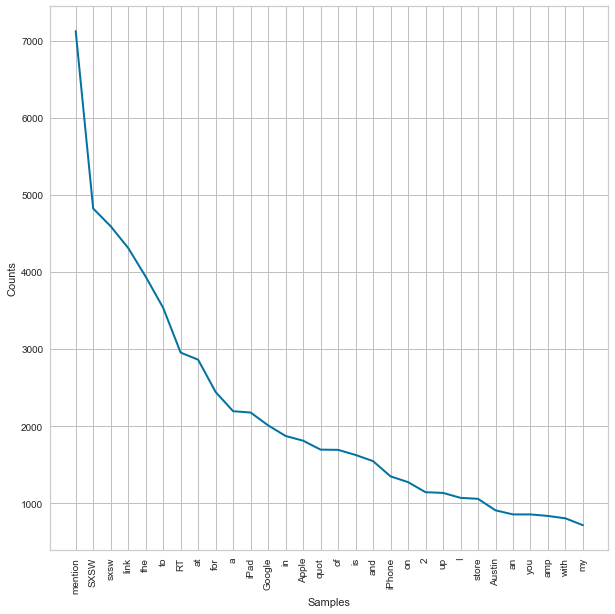

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [13]:
plt.figure(figsize=(10,10))
fdist.plot(30)

In [14]:
filtered_review = []

for w in tokenized_review:
    if w.lower() not in stopwords.words('english'):
        filtered_review.append(w.lower())

<FreqDist with 9808 samples and 115351 outcomes>


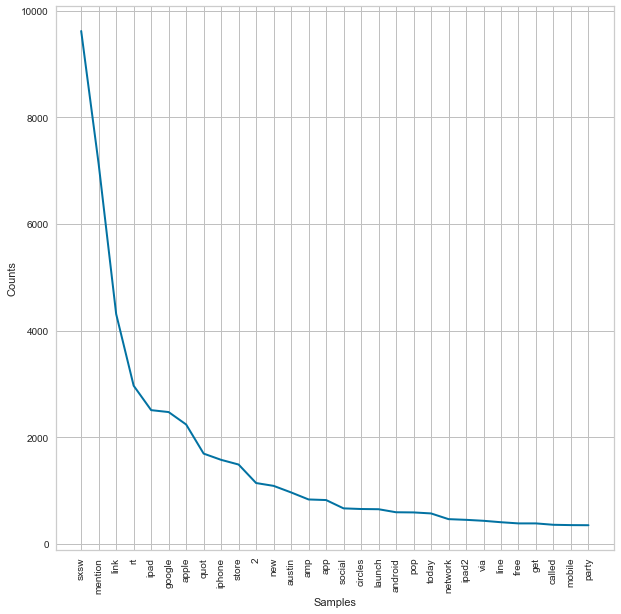

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [15]:
fdist = FreqDist(filtered_review)
print(fdist)
plt.figure(figsize=(10,10))
fdist.plot(30)

In [16]:
lemmatizer = WordNetLemmatizer()

lemmatized_review = []
for w in filtered_review:
    lemmatized_review.append(lemmatizer.lemmatize(w))


In [17]:
lemmatized_review

['wesley83',
 '3g',
 'iphone',
 '3',
 'hr',
 'tweeting',
 'rise',
 'austin',
 'dead',
 'need',
 'upgrade',
 'plugin',
 'station',
 'sxsw',
 'jessedee',
 'know',
 'fludapp',
 'awesome',
 'ipad',
 'iphone',
 'app',
 'likely',
 'appreciate',
 'design',
 'also',
 "they're",
 'giving',
 'free',
 't',
 'sxsw',
 'swonderlin',
 'wait',
 'ipad',
 '2',
 'also',
 'sale',
 'sxsw',
 'sxsw',
 'hope',
 "year's",
 'festival',
 'crashy',
 "year's",
 'iphone',
 'app',
 'sxsw',
 'sxtxstate',
 'great',
 'stuff',
 'fri',
 'sxsw',
 'marissa',
 'mayer',
 'google',
 'tim',
 "o'reilly",
 'tech',
 'book',
 'conference',
 'amp',
 'matt',
 'mullenweg',
 'wordpress',
 'teachntech00',
 'new',
 'ipad',
 'apps',
 'speechtherapy',
 'communication',
 'showcased',
 'sxsw',
 'conference',
 'http',
 'ht',
 'ly',
 '49n4m',
 'iear',
 'edchat',
 'asd',
 'unknown',
 'sxsw',
 'starting',
 'ctia',
 'around',
 'corner',
 'googleio',
 'hop',
 'skip',
 'jump',
 'good',
 'time',
 'android',
 'fan',
 'beautifully',
 'smart',
 'simpl

<FreqDist with 9061 samples and 115351 outcomes>


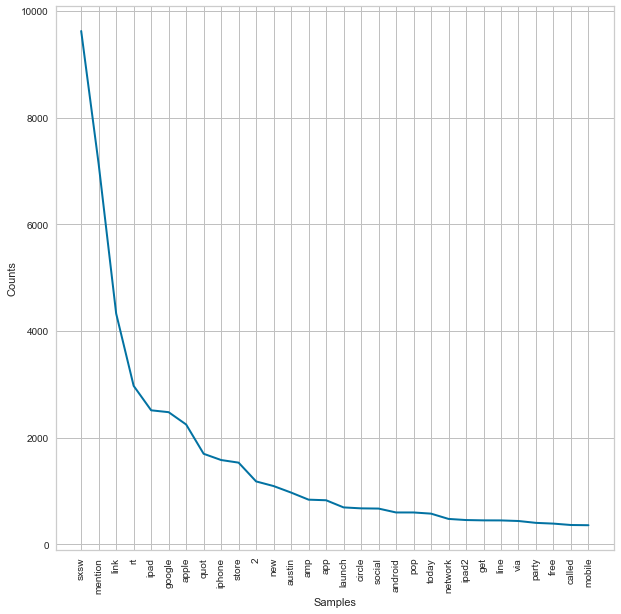

<AxesSubplot:xlabel='Samples', ylabel='Counts'>

In [18]:
fdist = FreqDist(lemmatized_review)
print(fdist)
plt.figure(figsize=(10,10))
fdist.plot(30)

Words to add to stopword list: mention, link, rt, quot

In [19]:
sw_list = stopwords.words('english')
sw_list += ['mention', 'link', 'rt', 'quot']

Most Frequent Words

In [20]:
df_freq_positive = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion']
df_freq_negative = df[df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion']

In [21]:
data_positive = df_freq_positive['tweet_text']
data_negative = df_freq_negative['tweet_text']

In [22]:
data_positive

1       @jessedee Know about @fludapp ? Awesome iPad/i...
2       @swonderlin Can not wait for #iPad 2 also. The...
4       @sxtxstate great stuff on Fri #SXSW: Marissa M...
7       #SXSW is just starting, #CTIA is around the co...
8       Beautifully smart and simple idea RT @madebyma...
                              ...                        
9072    @mention your iPhone 4 cases are Rad and Ready...
9077    @mention your PR guy just convinced me to swit...
9079    &quot;papyrus...sort of like the ipad&quot; - ...
9085    I've always used Camera+ for my iPhone b/c it ...
9088                        Ipad everywhere. #SXSW {link}
Name: tweet_text, Length: 2978, dtype: object

In [23]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')

data_positive = data_positive.apply(lambda x: tokenizer.tokenize(x))
data_negative = data_negative.apply(lambda x: tokenizer.tokenize(x))

<FreqDist with 5020 samples and 36043 outcomes>


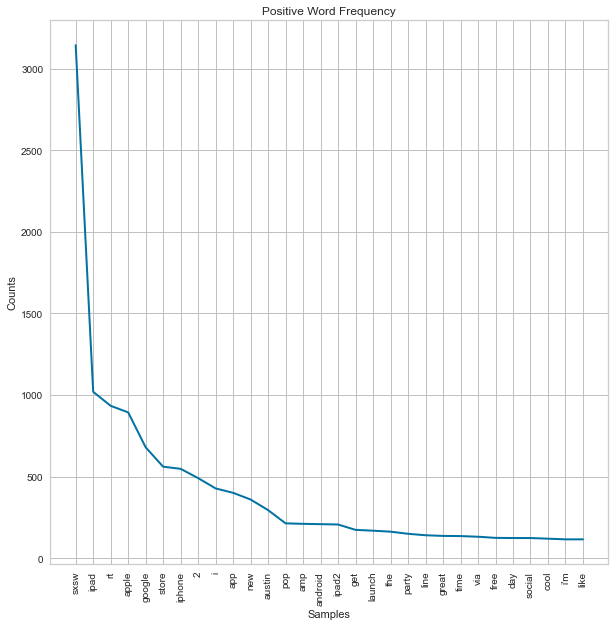

<AxesSubplot:title={'center':'Positive Word Frequency'}, xlabel='Samples', ylabel='Counts'>

In [24]:
tokenized_review = []
for row in data_positive:
    for w in row:
        if w not in sw_list:
            w = lemmatizer.lemmatize(w)
            tokenized_review.append(w.lower())

positive_fdist = FreqDist(tokenized_review)
print(positive_fdist)
plt.figure(figsize=(10,10))
plt.title('Positive Word Frequency')
positive_fdist.plot(30)

<FreqDist with 2072 samples and 7092 outcomes>


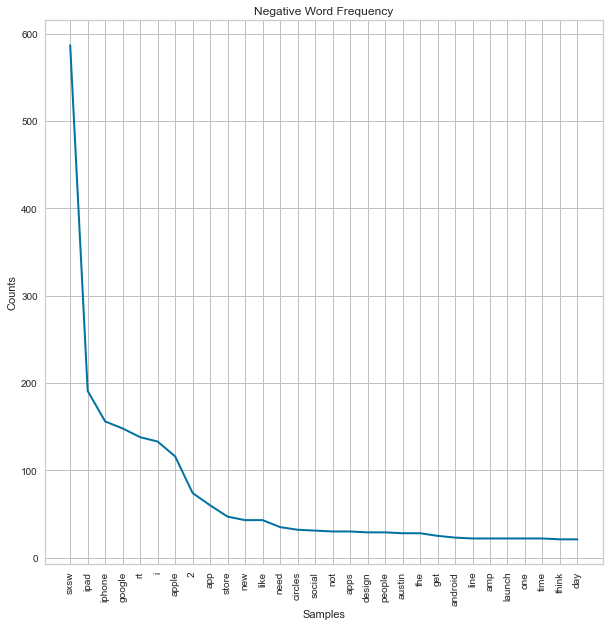

<AxesSubplot:title={'center':'Negative Word Frequency'}, xlabel='Samples', ylabel='Counts'>

In [25]:
tokenized_review = []
for row in data_negative:
    for w in row:
        if w not in sw_list:
            w = lemmatizer.lemmatize(w)
            tokenized_review.append(w.lower())

negative_fdist = FreqDist(tokenized_review)
print(negative_fdist)
plt.figure(figsize=(10,10))
plt.title('Negative Word Frequency')
negative_fdist.plot(30)

In [26]:
positive_fdist.most_common(20)

[('sxsw', 3144),
 ('ipad', 1020),
 ('rt', 934),
 ('apple', 894),
 ('google', 680),
 ('store', 561),
 ('iphone', 548),
 ('2', 491),
 ('i', 428),
 ('app', 401),
 ('new', 360),
 ('austin', 295),
 ('pop', 214),
 ('amp', 211),
 ('android', 209),
 ('ipad2', 207),
 ('get', 174),
 ('launch', 169),
 ('the', 163),
 ('party', 150)]

In [27]:
negative_fdist.most_common(20)

[('sxsw', 587),
 ('ipad', 191),
 ('iphone', 156),
 ('google', 148),
 ('rt', 138),
 ('i', 133),
 ('apple', 116),
 ('2', 74),
 ('app', 60),
 ('store', 47),
 ('new', 43),
 ('like', 43),
 ('need', 35),
 ('circles', 32),
 ('social', 31),
 ('not', 30),
 ('apps', 30),
 ('design', 29),
 ('people', 29),
 ('austin', 28)]

normalize frequencies

array([[<AxesSubplot:title={'center':'Frequency'}, xlabel='Word'>,
        <AxesSubplot:title={'center':'Normalized Frequency'}, xlabel='Word'>]],
      dtype=object)

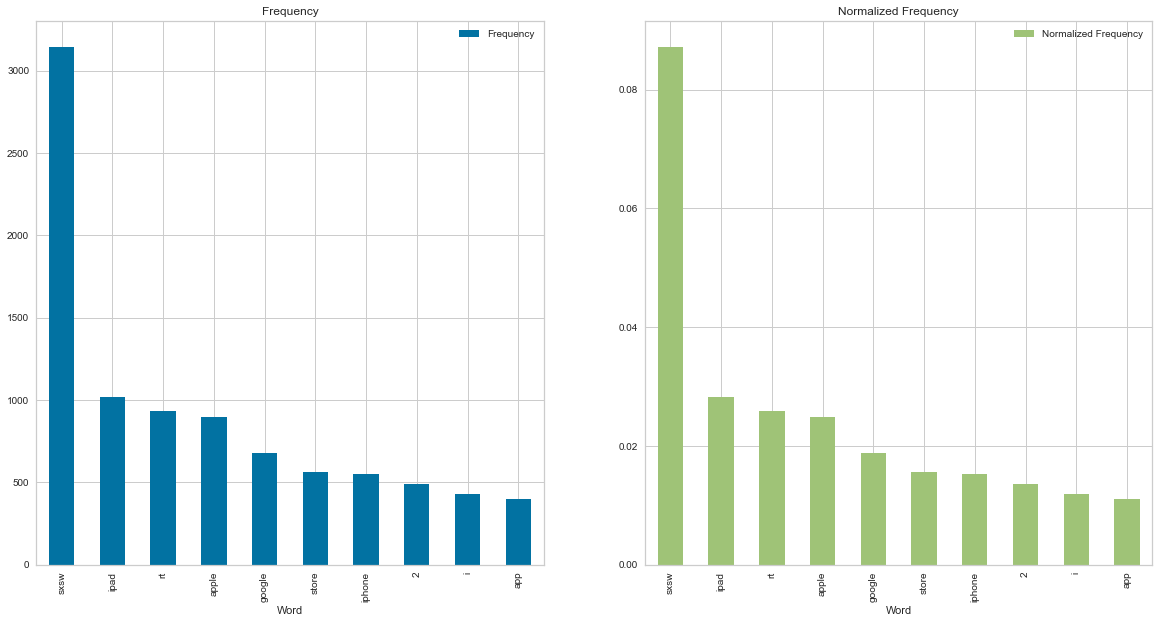

In [28]:
positive_total_word_count = sum(positive_fdist.values())
positive_tops = positive_fdist.most_common(20)
positive_frequency_df = pd.DataFrame(positive_tops, columns=['Word', 'Frequency'])
positive_frequency_df = positive_frequency_df.set_index('Word')
positive_frequency_df['Normalized Frequency'] = positive_frequency_df['Frequency']/positive_total_word_count
positive_frequency_df.nlargest(10, columns=['Frequency']).plot(kind='bar', subplots=True, sharex= False, layout=(1,2), figsize=(20,10))

<AxesSubplot:xlabel='Word'>

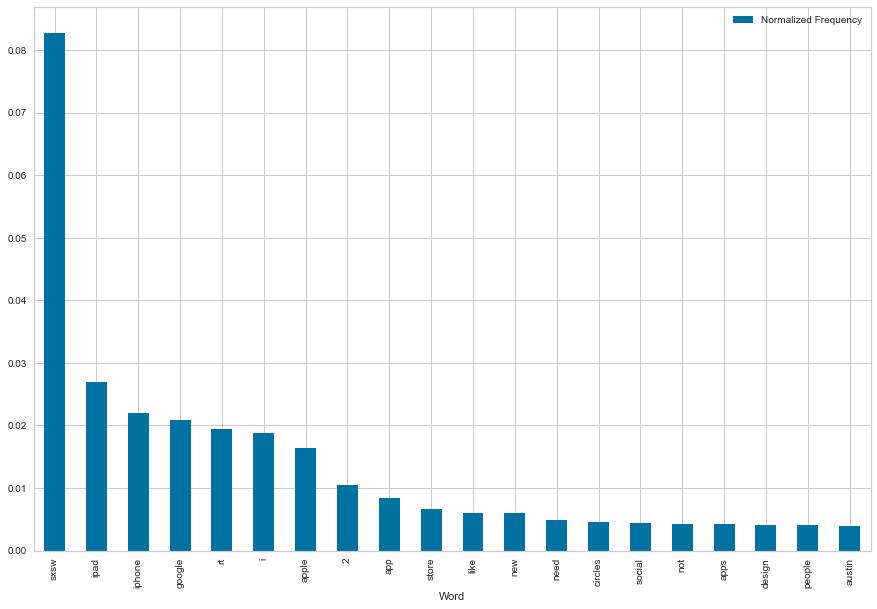

In [29]:
negative_total_word_count = sum(negative_fdist.values())
negative_tops = negative_fdist.most_common(20)
negative_frequency_df = pd.DataFrame(negative_tops, columns=['Word', 'Frequency'])
negative_frequency_df = negative_frequency_df.set_index('Word')
negative_frequency_df['Normalized Frequency'] = negative_frequency_df['Frequency']/negative_total_word_count
negative_frequency_df
negative_frequency_df.nlargest(20, columns=['Frequency']).plot(kind='bar', y = 'Normalized Frequency', figsize=(15,10))

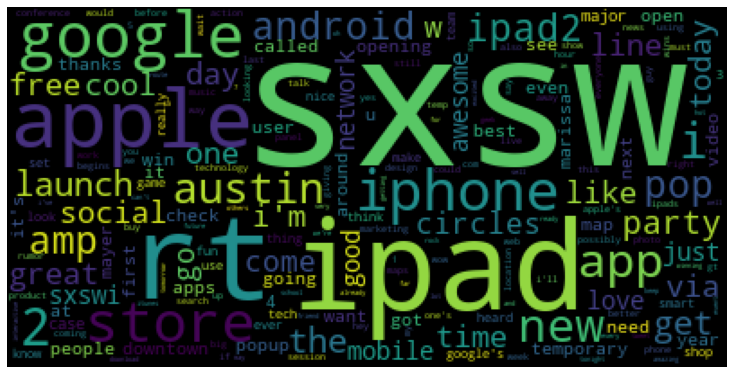

In [30]:

wordcloud = WordCloud().generate_from_frequencies(positive_fdist)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()

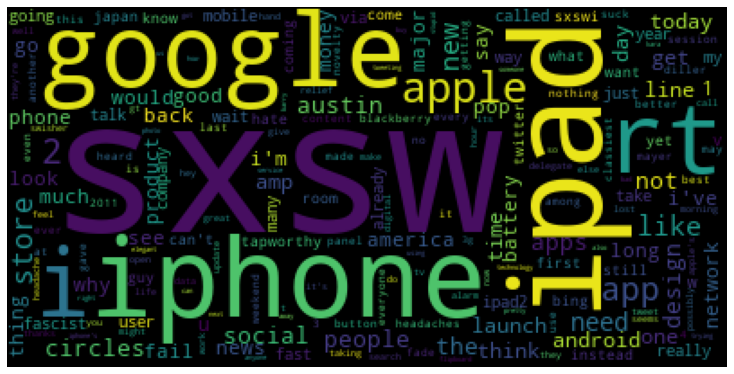

{'jessedee': 1,
 'know': 51,
 'fludapp': 1,
 'awesome': 95,
 'ipad': 1020,
 'iphone': 548,
 'app': 401,
 'likely': 2,
 'appreciate': 4,
 'design': 42,
 'also': 39,
 "they're": 19,
 'giving': 32,
 'free': 125,
 'ts': 2,
 'sxsw': 3144,
 'swonderlin': 1,
 'can': 4,
 'wait': 38,
 '2': 491,
 'they': 23,
 'sale': 17,
 'sxtxstate': 4,
 'great': 137,
 'stuff': 17,
 'fri': 5,
 'marissa': 61,
 'mayer': 66,
 'google': 680,
 'tim': 9,
 "o'reilly": 2,
 'tech': 55,
 'book': 22,
 'conference': 46,
 'amp': 211,
 'matt': 3,
 'mullenweg': 2,
 'wordpress': 3,
 'starting': 7,
 'ctia': 2,
 'around': 67,
 'corner': 5,
 'googleio': 2,
 'hop': 3,
 'skip': 2,
 'jump': 5,
 'good': 93,
 'time': 136,
 'android': 209,
 'fan': 17,
 'beautifully': 2,
 'smart': 49,
 'simple': 5,
 'idea': 23,
 'rt': 934,
 'madebymany': 7,
 'thenextweb': 1,
 'wrote': 6,
 'hollergram': 23,
 'http': 14,
 'bit': 18,
 'ly': 15,
 'ieavob': 1,
 'counting': 2,
 'day': 124,
 'plus': 8,
 'strong': 6,
 'canadian': 6,
 'dollar': 7,
 'mean': 14,
 

In [31]:
wordcloud = WordCloud().generate_from_frequencies(negative_fdist)

plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad=0)

plt.show()
dict(positive_fdist)

In [32]:

#TODO: simple model, pure text search based on collection of negative and positive words


In [33]:
# lists of negative and positive words from enchantedlearning.com
from bs4 import BeautifulSoup
import requests

negative_words_url = "https://www.enchantedlearning.com/wordlist/negativewords.shtml"
positive_words_url = "https://www.enchantedlearning.com/wordlist/positivewords.shtml"

html = requests.get(negative_words_url).content

soup = BeautifulSoup(html)

negative_divs = soup.find_all("div", {"class": "wordlist-item"})

negative_words = [x.get_text() for x in negative_divs]

html = requests.get(positive_words_url).content

soup = BeautifulSoup(html)

positive_divs = soup.find_all("div", {"class": "wordlist-item"})

positive_words = [x.get_text() for x in positive_divs]

In [34]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []

for row in df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word))
    data.append(r)
    r = []

data = pd.Series(data, name='tweet_text')
target = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [35]:
simple_model_df = pd.DataFrame([data, target]).transpose()

simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",Negative emotion
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",Positive emotion
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",Positive emotion
3,"[sxsw, I, hope, this, year's, festival, isn't,...",Negative emotion
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",Positive emotion
...,...,...
9088,"[Ipad, everywhere, SXSW, link]",Positive emotion
9089,"[Wave, buzz, RT, mention, We, interrupt, your,...",No emotion toward brand or product
9090,"[Google's, Zeiger, a, physician, never, report...",No emotion toward brand or product
9091,"[Some, Verizon, iPhone, customer, complained, ...",No emotion toward brand or product


In [36]:
def word_search_model(*arg, neutral_option=True):
#     print(arg)
    
    tweet = arg
    sentiment_score = 0
    
    
    if type(tweet) == list:
        pass
    elif type(tweet) == tuple:
        tweet = tweet[0]
    elif type(tweet) == str:
        r = []
        for word in tokenizer.tokenize(tweet):
            r.append(lemmatizer.lemmatize(word))
        tweet = r
    
#     print(tweet)
    
    for word in tweet:
#         print(word)
        if word in positive_words:
            sentiment_score += 1
        elif word in negative_words:
            sentiment_score -= 1
#     print(sentiment_score)
    if neutral_option == True:
        if sentiment_score > 0:
            sentiment_score = 1
    else:
        if sentiment_score >= 0:
            sentiment_score = 1
    if sentiment_score < 0:
        sentiment_score = -1

    return sentiment_score
    

In [37]:
simple_model_df['prediction'] = simple_model_df['tweet_text'].apply(word_search_model)

In [38]:
simple_model_df['prediction'].value_counts()

 0    5775
 1    2659
-1     659
Name: prediction, dtype: int64

In [39]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",Negative emotion,-1
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",Positive emotion,1
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",Positive emotion,-1
3,"[sxsw, I, hope, this, year's, festival, isn't,...",Negative emotion,0
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",Positive emotion,1
...,...,...,...
9088,"[Ipad, everywhere, SXSW, link]",Positive emotion,0
9089,"[Wave, buzz, RT, mention, We, interrupt, your,...",No emotion toward brand or product,0
9090,"[Google's, Zeiger, a, physician, never, report...",No emotion toward brand or product,-1
9091,"[Some, Verizon, iPhone, customer, complained, ...",No emotion toward brand or product,0


In [40]:
simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] = simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else(-1 if x == 'Negative emotion' else 0))

In [41]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",-1,-1
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",1,1
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",1,-1
3,"[sxsw, I, hope, this, year's, festival, isn't,...",-1,0
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",1,1
...,...,...,...
9088,"[Ipad, everywhere, SXSW, link]",1,0
9089,"[Wave, buzz, RT, mention, We, interrupt, your,...",0,0
9090,"[Google's, Zeiger, a, physician, never, report...",0,-1
9091,"[Some, Verizon, iPhone, customer, complained, ...",0,0


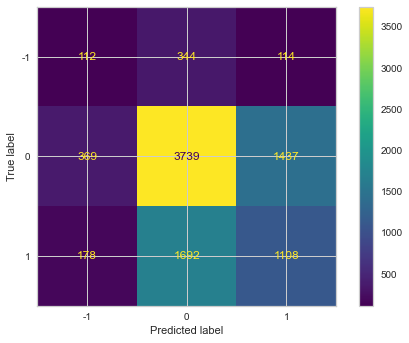

In [42]:
ConfusionMatrixDisplay.from_predictions(simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df['prediction'])

# confusion_matrix(word_search_model, simple_model_df['tweet_text'], simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'])

Simple Model without neutral

In [45]:
filtered_df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

In [47]:
filtered_df = filtered_df.reset_index()

In [48]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []


for row in filtered_df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word))
    data.append(r)
    r = []

data = pd.Series(data, name='tweet_text')
target = filtered_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [49]:
data

0       [wesley83, I, have, a, 3G, iPhone, After, 3, h...
1       [jessedee, Know, about, fludapp, Awesome, iPad...
2       [swonderlin, Can, not, wait, for, iPad, 2, als...
3       [sxsw, I, hope, this, year's, festival, isn't,...
4       [sxtxstate, great, stuff, on, Fri, SXSW, Maris...
                              ...                        
3543    [mention, your, PR, guy, just, convinced, me, ...
3544    [quot, papyrus, sort, of, like, the, ipad, quo...
3545    [Diller, say, Google, TV, quot, might, be, run...
3546    [I've, always, used, Camera, for, my, iPhone, ...
3547                       [Ipad, everywhere, SXSW, link]
Name: tweet_text, Length: 3548, dtype: object

In [50]:
simple_model_df = pd.DataFrame([data, target]).transpose()

simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",Negative emotion
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",Positive emotion
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",Positive emotion
3,"[sxsw, I, hope, this, year's, festival, isn't,...",Negative emotion
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",Positive emotion
...,...,...
3543,"[mention, your, PR, guy, just, convinced, me, ...",Positive emotion
3544,"[quot, papyrus, sort, of, like, the, ipad, quo...",Positive emotion
3545,"[Diller, say, Google, TV, quot, might, be, run...",Negative emotion
3546,"[I've, always, used, Camera, for, my, iPhone, ...",Positive emotion


In [51]:
simple_model_df['prediction'] = simple_model_df['tweet_text'].apply(lambda x: word_search_model(x, neutral_option=False))

In [52]:
simple_model_df['prediction'].value_counts()

 1    3258
-1     290
Name: prediction, dtype: int64

In [53]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",Negative emotion,-1
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",Positive emotion,1
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",Positive emotion,-1
3,"[sxsw, I, hope, this, year's, festival, isn't,...",Negative emotion,1
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",Positive emotion,1
...,...,...,...
3543,"[mention, your, PR, guy, just, convinced, me, ...",Positive emotion,1
3544,"[quot, papyrus, sort, of, like, the, ipad, quo...",Positive emotion,1
3545,"[Diller, say, Google, TV, quot, might, be, run...",Negative emotion,1
3546,"[I've, always, used, Camera, for, my, iPhone, ...",Positive emotion,1


In [54]:
simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'] = simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'].apply(lambda x: 1 if x == 'Positive emotion' else(-1 if x == 'Negative emotion' else 0))

In [55]:
simple_model_df

,tweet_text,is_there_an_emotion_directed_at_a_brand_or_product,prediction
0,"[wesley83, I, have, a, 3G, iPhone, After, 3, h...",-1,-1
1,"[jessedee, Know, about, fludapp, Awesome, iPad...",1,1
2,"[swonderlin, Can, not, wait, for, iPad, 2, als...",1,-1
3,"[sxsw, I, hope, this, year's, festival, isn't,...",-1,1
4,"[sxtxstate, great, stuff, on, Fri, SXSW, Maris...",1,1
...,...,...,...
3543,"[mention, your, PR, guy, just, convinced, me, ...",1,1
3544,"[quot, papyrus, sort, of, like, the, ipad, quo...",1,1
3545,"[Diller, say, Google, TV, quot, might, be, run...",-1,1
3546,"[I've, always, used, Camera, for, my, iPhone, ...",1,1


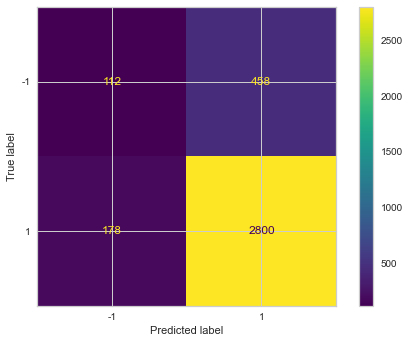

In [56]:
ConfusionMatrixDisplay.from_predictions(simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'], simple_model_df['prediction'])

# confusion_matrix(word_search_model, simple_model_df['tweet_text'], simple_model_df['is_there_an_emotion_directed_at_a_brand_or_product'])

classify


In [57]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []

for row in df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word))
    data.append(' '.join(r))
    r = []

data = pd.Series(data, name='tweet_text')
target = df['is_there_an_emotion_directed_at_a_brand_or_product']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)


# tfidf_data_train = tfidf.fit_transform(X_train)
# tfidf_data_test = tfidf.transform(X_test)

# tfidf_data_train

In [59]:
lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('lr', LogisticRegression())])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('RandomForest', RandomForestClassifier())])

models = [('lr', lr),
          ('Tree', tree),
          ('RandomForest', rf)
         ]

scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

[('lr', 0.6605081878848389),
 ('Tree', 0.6088203657918648),
 ('RandomForest', 0.655009694416173)]

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1360: UserWarning: Note that pos_label (set to 'Positive emotion') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\metrics\_classification.py:13

Train Scores
------------
Accuracy: 0.7958644962604488
F1 Score: 0.473329711659441
ROC-AUC: 0.9346815769319811
Precision: 0.6429877125555795
-----------------------------------
Val Scores
-----------
Accuracy: 0.679419525065963
F1 Score: 0.3603794679506146
ROC-AUC: 0.7060216492336656
Precision: 0.5005661261308085


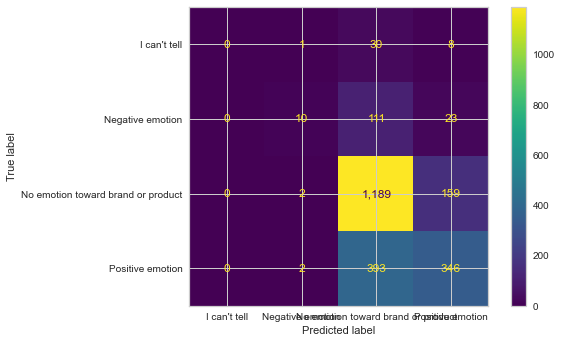

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


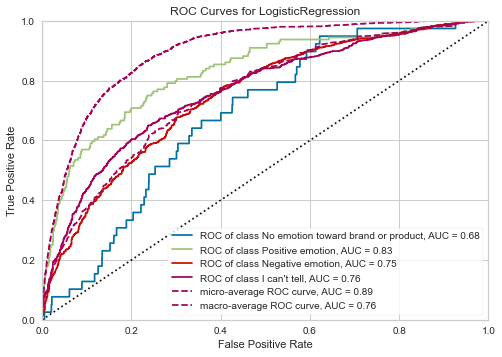

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


go
Positive Appearences: 105
Negative Appearences: 17

nut
Positive Appearences: 3
Negative Appearences: 1

circles
Positive Appearences: 106
Negative Appearences: 32

game
Positive Appearences: 50
Negative Appearences: 3

gave
Positive Appearences: 9
Negative Appearences: 10

fight
Positive Appearences: 5
Negative Appearences: 0

equal
Positive Appearences: 0
Negative Appearences: 0

rww
Positive Appearences: 0
Negative Appearences: 1

tsunami
Positive Appearences: 2
Negative Appearences: 1

home
Positive Appearences: 19
Negative Appearences: 2

four
Positive Appearences: 5
Negative Appearences: 0

arrested
Positive Appearences: 0
Negative Appearences: 0

fragmentation
Positive Appearences: 0
Negative Appearences: 1

give
Positive Appearences: 22
Negative Appearences: 8

becomes
Positive Appearences: 0
Negative Appearences: 0

club
Positive Appearences: 0
Negative Appearences: 0

think
Positive Appearences: 53
Negative Appearences: 21

staring
Positive Appearences: 3
Negative Appearen

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1360: UserWarning: Note that pos_label (set to 'Positive emotion') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1360: UserWarning: Note that pos_label (set to 'Positive emotion') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1360: UserWarning: Note that pos_label (set to 'Positive emotion') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\stone\pycharmprojects\sen

Train Scores
------------
Accuracy: 0.96025810236105
F1 Score: 0.9461086885707353
ROC-AUC: 0.9984234681807549
Precision: 0.9305304572220896
-----------------------------------
Val Scores
-----------
Accuracy: 0.6213720316622692
F1 Score: 0.4009513726194327
ROC-AUC: 0.5919220152620727
Precision: 0.42180324239453953


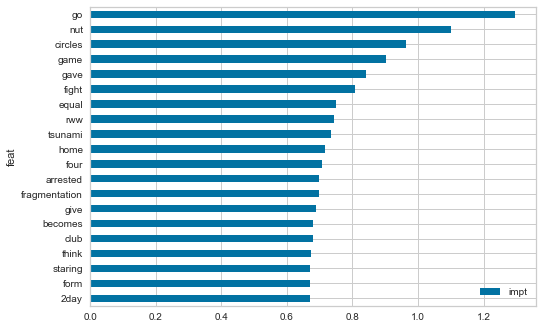

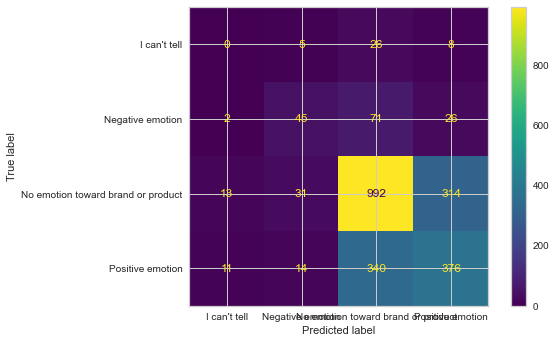

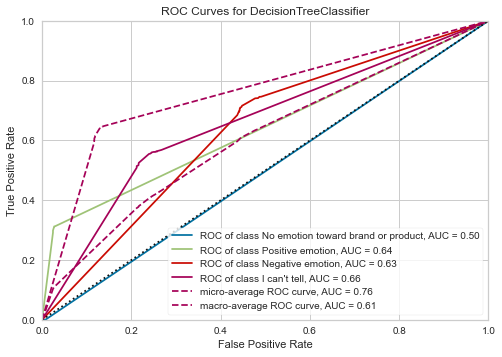

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


sxsw
Positive Appearences: 3144
Negative Appearences: 587

apple
Positive Appearences: 894
Negative Appearences: 116

ipad
Positive Appearences: 1020
Negative Appearences: 191

iphone
Positive Appearences: 548
Negative Appearences: 156

google
Positive Appearences: 680
Negative Appearences: 148

android
Positive Appearences: 209
Negative Appearences: 23

cool
Positive Appearences: 120
Negative Appearences: 5

app
Positive Appearences: 401
Negative Appearences: 60

great
Positive Appearences: 137
Negative Appearences: 8

ipad2
Positive Appearences: 207
Negative Appearences: 13

amp
Positive Appearences: 211
Negative Appearences: 22

even
Positive Appearences: 71
Negative Appearences: 9

awesome
Positive Appearences: 95
Negative Appearences: 4

austin
Positive Appearences: 295
Negative Appearences: 28

pop
Positive Appearences: 214
Negative Appearences: 17

store
Positive Appearences: 561
Negative Appearences: 47

get
Positive Appearences: 174
Negative Appearences: 25

time
Positive Appe

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1360: UserWarning: Note that pos_label (set to 'Positive emotion') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1360: UserWarning: Note that pos_label (set to 'Positive emotion') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\metrics\_classification.py:1360: UserWarning: Note that pos_label (set to 'Positive emotion') is ignored when average != 'binary' (got 'macro'). You may use labels=[pos_label] to specify a single positive class.
  warnings.warn(
c:\users\stone\pycharmprojects\sen

Train Scores
------------
Accuracy: 0.96025810236105
F1 Score: 0.9423390461285667
ROC-AUC: 0.99798810719156
Precision: 0.9636387822221002
-----------------------------------
Val Scores
-----------
Accuracy: 0.6715039577836411
F1 Score: 0.3966655788697264
ROC-AUC: 0.6951609216421688
Precision: 0.488091603446125


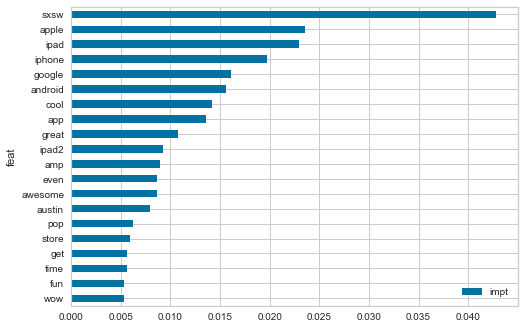

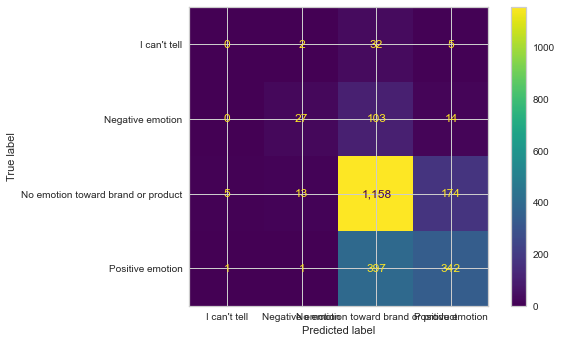

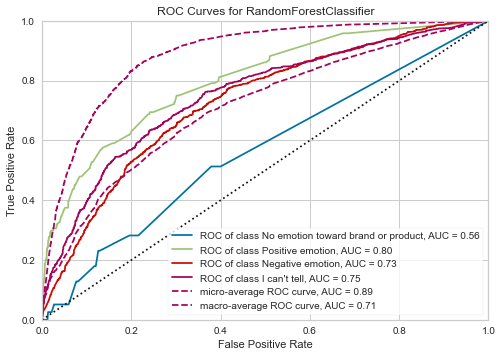

sxsw
Positive Appearences: 3144
Negative Appearences: 587

ipad
Positive Appearences: 1020
Negative Appearences: 191

apple
Positive Appearences: 894
Negative Appearences: 116

google
Positive Appearences: 680
Negative Appearences: 148

app
Positive Appearences: 401
Negative Appearences: 60

iphone
Positive Appearences: 548
Negative Appearences: 156

cool
Positive Appearences: 120
Negative Appearences: 5

store
Positive Appearences: 561
Negative Appearences: 47

awesome
Positive Appearences: 95
Negative Appearences: 4

new
Positive Appearences: 360
Negative Appearences: 43

austin
Positive Appearences: 295
Negative Appearences: 28

great
Positive Appearences: 137
Negative Appearences: 8

amp
Positive Appearences: 211
Negative Appearences: 22

good
Positive Appearences: 93
Negative Appearences: 15

pop
Positive Appearences: 214
Negative Appearences: 17

ipad2
Positive Appearences: 207
Negative Appearences: 13

wow
Positive Appearences: 43
Negative Appearences: 3

smart
Positive Appearen

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


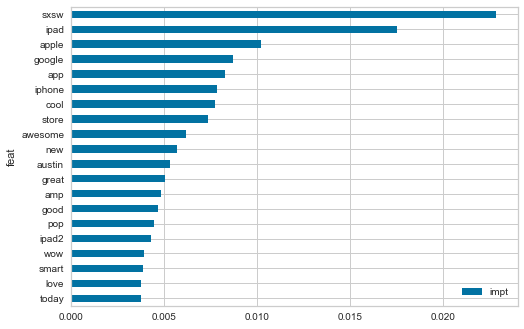

In [60]:
for name, model in models:
    run_model(name, model, X_train, X_test, y_train, y_test)

# re-do without no emotion, can't tell

In [61]:
df['is_there_an_emotion_directed_at_a_brand_or_product'].value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: is_there_an_emotion_directed_at_a_brand_or_product, dtype: int64

In [62]:
filtered_df = df[(df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Positive emotion') | (df['is_there_an_emotion_directed_at_a_brand_or_product'] == 'Negative emotion')]

In [63]:
filtered_df = filtered_df.reset_index()

In [64]:
tokenizer = RegexpTokenizer(r'[a-zA-Z0-9\']+')
lemmatizer = WordNetLemmatizer()

r = []
data = []

for row in filtered_df['tweet_text']:
    for word in tokenizer.tokenize(row):
        r.append(lemmatizer.lemmatize(word))
    data.append(' '.join(r))
    r = []

data = pd.Series(data, name='tweet_text')
target = filtered_df['is_there_an_emotion_directed_at_a_brand_or_product']

In [65]:
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state=42)


# tfidf_data_train = tfidf.fit_transform(X_train)
# tfidf_data_test = tfidf.transform(X_test)

# tfidf_data_train

In [66]:
lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('lr', LogisticRegression())])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('RandomForest', RandomForestClassifier())])

models = [('lr', lr),
          ('Tree', tree),
          ('RandomForest', rf)
         ]

scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

[('lr', 0.8418827508455469),
 ('Tree', 0.8156708004509583),
 ('RandomForest', 0.8683765501691094)]

Train Scores
------------
Accuracy: 0.8594513340849305
F1 Score: 0.9225352112676056
ROC-AUC: 0.9803441191470306
Precision: 0.8565384615384616
-----------------------------------
Val Scores
-----------
Accuracy: 0.85456595264938
F1 Score: 0.9208103130755064
ROC-AUC: 0.8541995133819951
Precision: 0.8532423208191127


c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


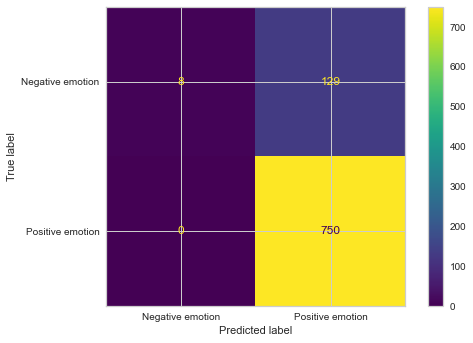

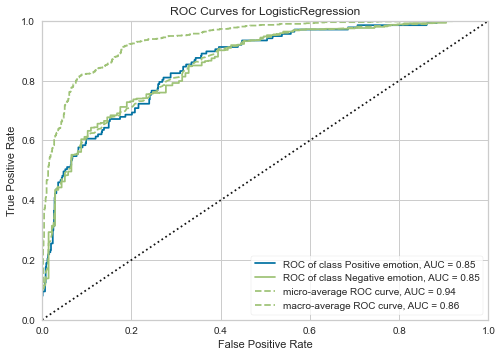

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


free
Positive Appearences: 125
Negative Appearences: 2

cool
Positive Appearences: 120
Negative Appearences: 5

new
Positive Appearences: 360
Negative Appearences: 43

party
Positive Appearences: 150
Negative Appearences: 6

great
Positive Appearences: 137
Negative Appearences: 8

win
Positive Appearences: 86
Negative Appearences: 2

ipad2
Positive Appearences: 207
Negative Appearences: 13

awesome
Positive Appearences: 95
Negative Appearences: 4

amp
Positive Appearences: 211
Negative Appearences: 22

store
Positive Appearences: 561
Negative Appearences: 47

fun
Positive Appearences: 51
Negative Appearences: 0

case
Positive Appearences: 57
Negative Appearences: 1

got
Positive Appearences: 81
Negative Appearences: 7

video
Positive Appearences: 60
Negative Appearences: 1

must
Positive Appearences: 33
Negative Appearences: 1

week
Positive Appearences: 43
Negative Appearences: 2

map
Positive Appearences: 77
Negative Appearences: 3

check
Positive Appearences: 85
Negative Appearences

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


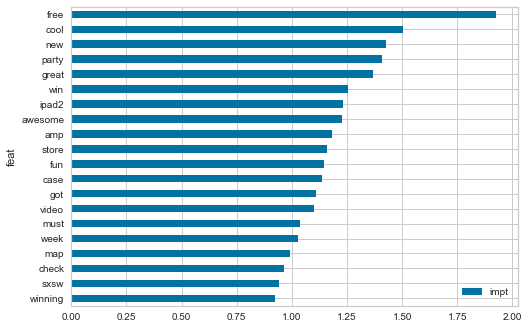

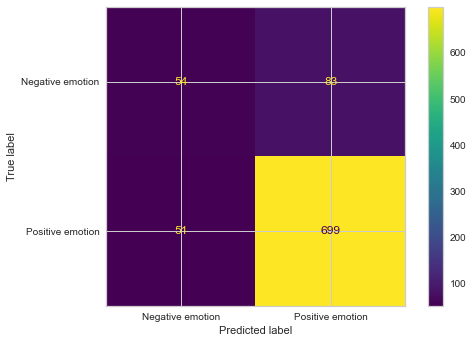

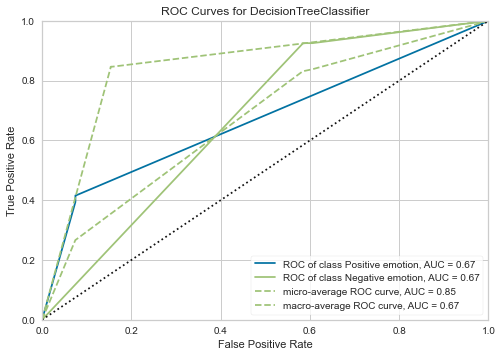

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


sxsw
Positive Appearences: 3144
Negative Appearences: 587

fascist
Positive Appearences: 0
Negative Appearences: 14

hate
Positive Appearences: 0
Negative Appearences: 10

fade
Positive Appearences: 0
Negative Appearences: 10

money
Positive Appearences: 4
Negative Appearences: 14

suck
Positive Appearences: 2
Negative Appearences: 10

fail
Positive Appearences: 7
Negative Appearences: 18

headaches
Positive Appearences: 2
Negative Appearences: 10

ipad
Positive Appearences: 1020
Negative Appearences: 191

battery
Positive Appearences: 12
Negative Appearences: 17

much
Positive Appearences: 26
Negative Appearences: 15

data
Positive Appearences: 11
Negative Appearences: 7

room
Positive Appearences: 11
Negative Appearences: 12

better
Positive Appearences: 38
Negative Appearences: 10

would
Positive Appearences: 39
Negative Appearences: 19

headache
Positive Appearences: 1
Negative Appearences: 7

autocorrect
Positive Appearences: 0
Negative Appearences: 4

tag
Positive Appearences: 0


c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


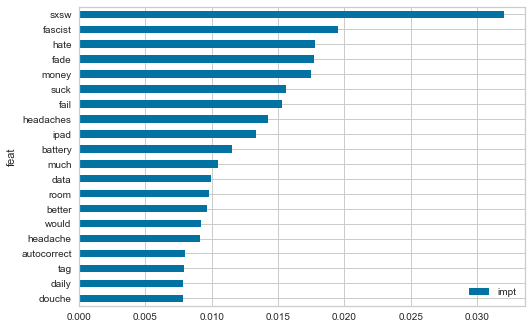

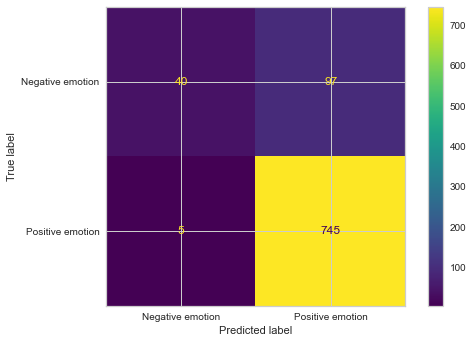

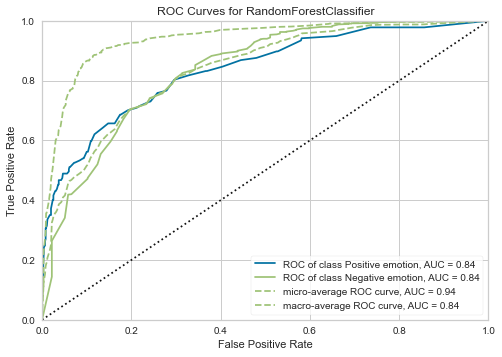

sxsw
Positive Appearences: 3144
Negative Appearences: 587

suck
Positive Appearences: 2
Negative Appearences: 10

hate
Positive Appearences: 0
Negative Appearences: 10

ipad
Positive Appearences: 1020
Negative Appearences: 191

fascist
Positive Appearences: 0
Negative Appearences: 14

fail
Positive Appearences: 7
Negative Appearences: 18

design
Positive Appearences: 42
Negative Appearences: 29

money
Positive Appearences: 4
Negative Appearences: 14

apple
Positive Appearences: 894
Negative Appearences: 116

iphone
Positive Appearences: 548
Negative Appearences: 156

battery
Positive Appearences: 12
Negative Appearences: 17

headaches
Positive Appearences: 2
Negative Appearences: 10

google
Positive Appearences: 680
Negative Appearences: 148

long
Positive Appearences: 20
Negative Appearences: 17

like
Positive Appearences: 116
Negative Appearences: 43

fade
Positive Appearences: 0
Negative Appearences: 10

call
Positive Appearences: 6
Negative Appearences: 8

delegate
Positive Appeare

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


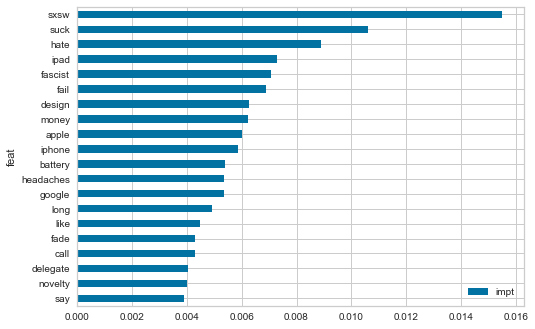

In [67]:
for name, model in models:
    run_model(name, model, X_train, X_test, y_train, y_test)

In [68]:
#TODO: logistic regression

# WORD VECTORIZATION

In [69]:
word_list = []

for w in fdist.keys():
    if w not in sw_list:
        w = lemmatizer.lemmatize(w)
        word_list.append(w.lower())

In [71]:
glove = {}
with open('glove.twitter.27B.25d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in word_list:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [72]:
glove

{'de': array([ 1.423   , -0.46838 , -0.16331 ,  1.2443  ,  1.0157  ,  1.1604  ,
        -2.0031  ,  2.5195  , -0.47779 , -1.8382  ,  0.32809 , -3.2301  ,
        -3.0671  , -0.2536  ,  0.87798 ,  0.3083  , -0.88685 ,  1.2904  ,
        -1.3443  ,  1.1462  , -0.026837, -0.449   , -0.006978, -0.73663 ,
         1.6404  ], dtype=float32),
 'que': array([ 1.8163  , -0.9435  , -0.6624  ,  1.0099  ,  0.031072,  0.33463 ,
        -0.95627 ,  2.9703  , -0.54155 , -2.4489  ,  0.29555 , -3.9631  ,
        -2.5559  , -0.5695  ,  1.0982  ,  0.73903 , -1.1868  ,  0.5865  ,
        -0.45852 ,  0.49212 ,  0.87361 ,  0.14368 ,  0.64574 ,  0.86255 ,
         0.4955  ], dtype=float32),
 'n': array([ 0.53229 , -0.30423 , -0.6065  , -0.15941 ,  0.52165 , -0.065076,
         1.3758  ,  2.4098  , -1.033   ,  0.73698 , -0.40591 , -0.18263 ,
        -2.7087  ,  0.28421 , -1.8023  , -1.4446  , -1.4078  , -0.20802 ,
        -0.94007 , -0.10846 ,  0.047255, -0.85601 ,  0.94209 ,  0.34083 ,
         0.66958 ], dt

In [73]:
len(glove)

7044

In [74]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [75]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

lsvc = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('LinearSVC', LinearSVC())])

tree = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Tree', DecisionTreeClassifier())])

In [76]:
lr = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('lr', LogisticRegression())])

tree = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('Tree', DecisionTreeClassifier())])

rf = Pipeline([('tfidfv', TfidfVectorizer(stop_words=sw_list)),
                ('RandomForest', RandomForestClassifier())])

models = [('lr', lr),
          ('Tree', tree),
          ('RandomForest', rf)
         ]

scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

scores

[('lr', 0.8418827508455469),
 ('Tree', 0.8086245772266065),
 ('RandomForest', 0.8666854565952649)]

Train Scores
------------
Accuracy: 0.8594513340849305
F1 Score: 0.9225352112676056
ROC-AUC: 0.9803441191470306
Precision: 0.8565384615384616
-----------------------------------
Val Scores
-----------
Accuracy: 0.85456595264938
F1 Score: 0.9208103130755064
ROC-AUC: 0.8541995133819951
Precision: 0.8532423208191127


c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


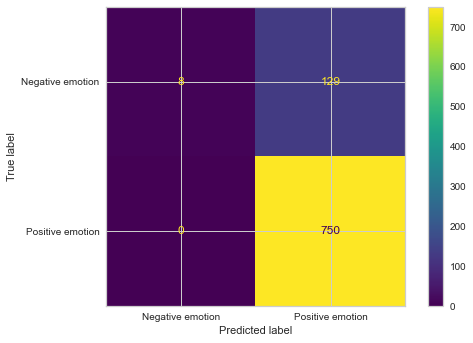

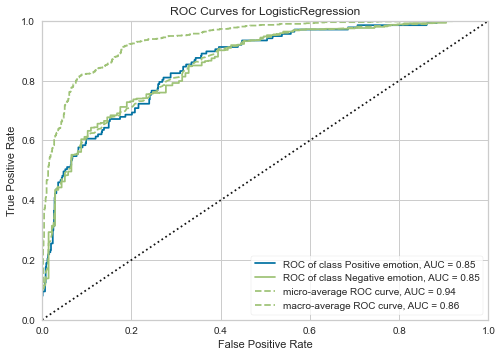

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


free
Positive Appearences: 125
Negative Appearences: 2

cool
Positive Appearences: 120
Negative Appearences: 5

new
Positive Appearences: 360
Negative Appearences: 43

party
Positive Appearences: 150
Negative Appearences: 6

great
Positive Appearences: 137
Negative Appearences: 8

win
Positive Appearences: 86
Negative Appearences: 2

ipad2
Positive Appearences: 207
Negative Appearences: 13

awesome
Positive Appearences: 95
Negative Appearences: 4

amp
Positive Appearences: 211
Negative Appearences: 22

store
Positive Appearences: 561
Negative Appearences: 47

fun
Positive Appearences: 51
Negative Appearences: 0

case
Positive Appearences: 57
Negative Appearences: 1

got
Positive Appearences: 81
Negative Appearences: 7

video
Positive Appearences: 60
Negative Appearences: 1

must
Positive Appearences: 33
Negative Appearences: 1

week
Positive Appearences: 43
Negative Appearences: 2

map
Positive Appearences: 77
Negative Appearences: 3

check
Positive Appearences: 85
Negative Appearences

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


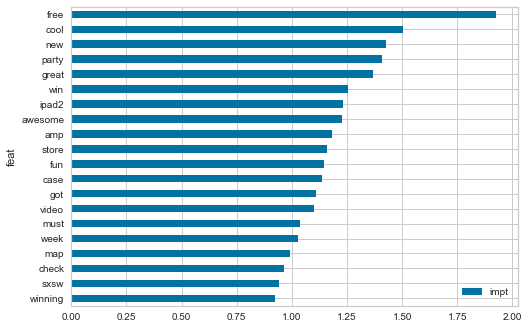

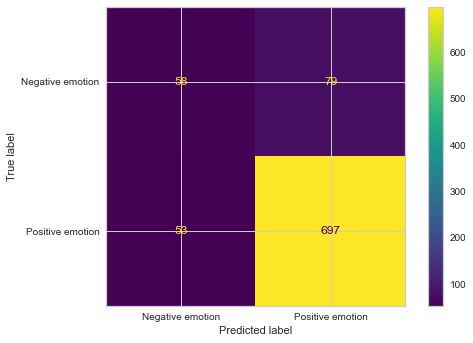

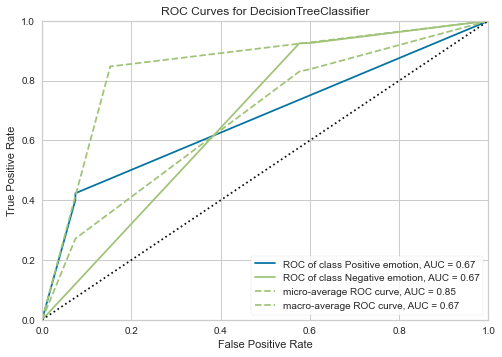

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


sxsw
Positive Appearences: 3144
Negative Appearences: 587

fascist
Positive Appearences: 0
Negative Appearences: 14

hate
Positive Appearences: 0
Negative Appearences: 10

fade
Positive Appearences: 0
Negative Appearences: 10

money
Positive Appearences: 4
Negative Appearences: 14

suck
Positive Appearences: 2
Negative Appearences: 10

fail
Positive Appearences: 7
Negative Appearences: 18

headaches
Positive Appearences: 2
Negative Appearences: 10

ipad
Positive Appearences: 1020
Negative Appearences: 191

battery
Positive Appearences: 12
Negative Appearences: 17

much
Positive Appearences: 26
Negative Appearences: 15

google
Positive Appearences: 680
Negative Appearences: 148

room
Positive Appearences: 11
Negative Appearences: 12

better
Positive Appearences: 38
Negative Appearences: 10

people
Positive Appearences: 82
Negative Appearences: 29

headache
Positive Appearences: 1
Negative Appearences: 7

tag
Positive Appearences: 0
Negative Appearences: 6

daily
Positive Appearences: 7


c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


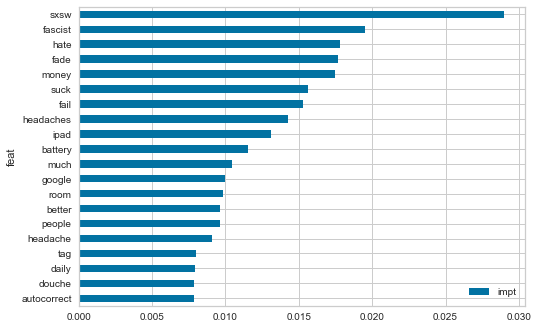

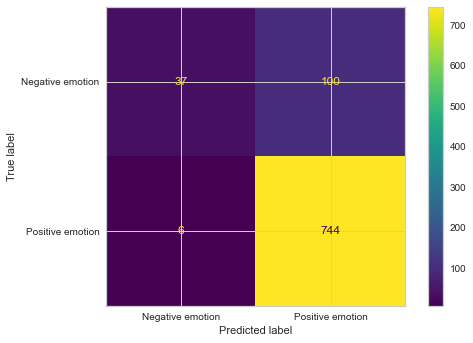

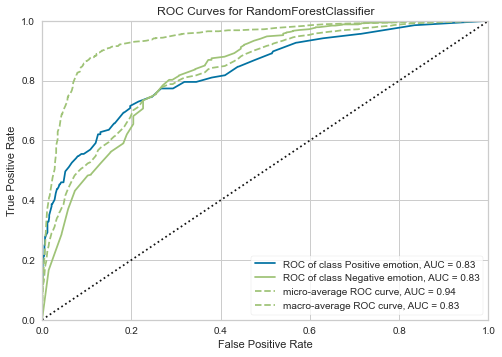

sxsw
Positive Appearences: 3144
Negative Appearences: 587

suck
Positive Appearences: 2
Negative Appearences: 10

hate
Positive Appearences: 0
Negative Appearences: 10

fail
Positive Appearences: 7
Negative Appearences: 18

design
Positive Appearences: 42
Negative Appearences: 29

money
Positive Appearences: 4
Negative Appearences: 14

battery
Positive Appearences: 12
Negative Appearences: 17

ipad
Positive Appearences: 1020
Negative Appearences: 191

fade
Positive Appearences: 0
Negative Appearences: 10

iphone
Positive Appearences: 548
Negative Appearences: 156

apple
Positive Appearences: 894
Negative Appearences: 116

long
Positive Appearences: 20
Negative Appearences: 17

america
Positive Appearences: 7
Negative Appearences: 15

headaches
Positive Appearences: 2
Negative Appearences: 10

much
Positive Appearences: 26
Negative Appearences: 15

need
Positive Appearences: 67
Negative Appearences: 35

fascist
Positive Appearences: 0
Negative Appearences: 14

like
Positive Appearences:

c:\users\stone\pycharmprojects\sentiment_analysis_nlp_project\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


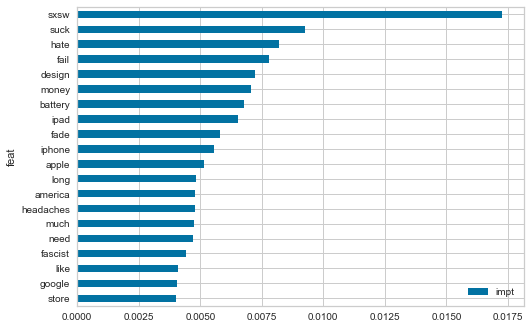

In [77]:
for name, model in models:
    run_model(name, model, X_train, X_test, y_train, y_test)

In [ ]:
#TODO: decision tree
#TODO: show metrics for why complex over simple model
#TODO: iterate models when justified